Calculating Energy Efficiency for an IRS-Assisted Wireless Network.
1. Using a 3D environment to model Base Station, IRS and Users.
2. Implementing on a 2 User system.
3. Starting with a Double-IRS Assisted Network, comparing energy efficiency for both Ideal and Practical Models.
4. Shifting to a Single IRS Assisted Network and comparing energy efficiency for both Ideal and Practical Models.
5. We have performed the comparison keeping in mind all three quantization bits, and considering element sharing to be true for all scenarios. 

In [1]:
# Importing all libraries

import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from Functions import *

In [2]:
#============== System parameters
'''
Defining Parameters
    Nt = Number of transmit antennas (SISO = 1)
    K = Number of Users
    BW = Bandwidth
    NF = Noise Floor
    ALPHA = PLE for indirect link (IRS-1)
    BETA = PLE for indirect link (IRS-2)
    ZETA = PLE for direct link 
    wn = efficiency of transmit power amplifier
    Pb = Power dissipated by BS
    Pu = Power dissipated by User
    loc_U = User positions
    m = Nakagami Shape parameter (m > 0, m = 1 corresponds to Rayleigh fading)
    omega = 1.0  Nakagami Spread parameter (omega > 0)
    Ns_max = Total number of IRS elements in a single IRS

'''
Nt = 1
K = 16
# gamma = db2pow(20)
f = 2.4e9
c = 3e8
Lambda = c/f
halfLambda = 0.5*Lambda
quarterLambda = 0.25*Lambda
BW = 20e6
NF = 10
noise = -133 # -174+10*np.log10(BW) + NF

# Network Parameters
GRID_RADIUS = 1000
BASE_STATION_POSITION = (0, 0, 20)
TRANSMIT_POWER_WATTS = 4 #in watts
NUM_SIMULATIONS = 100
# dThreshold = GRID_RADIUS/ 40

# Fading Paramters
FADING_STD_MEAN = 0
FADING_STD_DEV = np.sqrt(0.5)

# m = 1
# omega = 
# Path Loss Parameters
BETA1 = 2.8 #path loss exponent (indirect) bs -> irs
BETA2 = 2.2  #path loss exponent (indirect) irs -> user
ALPHA = 3.8 #path loss exponent (direct) bs -> user

# ALPHA = 2.2 #path loss exponent (indirect - IRS 1)
# BETA = 3.8 #path loss exponent  (indirect - IRS 1)
# ZETA = 3.8 #path loss exponent  (direct)

# IRS Positions
IRS_POSITION_1 = (60, 80, 10)
IRS_POSITION_2 = (60, -80, 10)
Ns_max = 400

# Power consumption params
wn = 0.5
Pb = 10 # in dBw
Pu = 10 # 10 in dBm

#Practical phase shift model paramters
a = 1.6
phi = 0.43 * np.pi
B_min = 0.2
# print(dThreshold)

Creating Network

User positions:
 [[-3.60456703e+01  3.59012453e+02  0.00000000e+00]
 [ 1.96470373e+02  7.23124757e+01  0.00000000e+00]
 [-1.44694371e+02 -2.15594585e+02  0.00000000e+00]
 [-1.31946783e+02 -6.46938626e+02  0.00000000e+00]
 [ 3.06838028e+01 -2.40899242e+02  0.00000000e+00]
 [-1.93337880e+02 -2.12919299e+02  0.00000000e+00]
 [ 9.71916508e+02  2.01301653e+02  0.00000000e+00]
 [ 1.39286292e+02  4.61707247e+02  0.00000000e+00]
 [ 3.64448302e+01  3.42670522e+01  0.00000000e+00]
 [-1.10476893e+02 -9.46356954e+00  0.00000000e+00]
 [-1.06734198e+02 -2.04155147e+02  0.00000000e+00]
 [ 2.29581748e+02  7.60249320e+01  0.00000000e+00]
 [-6.79425053e-01 -2.36686026e+00  0.00000000e+00]
 [ 2.14611022e+01  2.67193808e+01  0.00000000e+00]
 [-2.02858370e+02  1.11937702e+02  0.00000000e+00]
 [-9.18548752e+01  7.04404499e+01  0.00000000e+00]]
BS position:
 (0, 0, 20)
IRS-1 position:
 (60, 80, 10)
IRS-2 position:
 (60, -80, 10)
BS to User distance dTU:
 [[361.37132072 210.30858672 260.41790663 660.56001923 

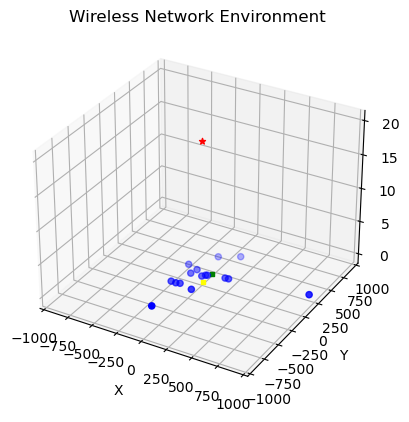

In [3]:

xt, yt, zt = BASE_STATION_POSITION
xs_1, ys_1, zs_1 = IRS_POSITION_1
xs_2, ys_2, zs_2 = IRS_POSITION_2


USER_POS = generate_user_positions_3D(K, GRID_RADIUS)
fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')
plt.scatter(xs_2, ys_2, zs_2, color='yellow', marker='s', label='IRS_2')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis([-1000,1000,-1000,1000])
ax.set_title('Wireless Network Environment')
# ax.legend()
ax.grid(True)

print('User positions:'"\n" , USER_POS)
print('BS position:'"\n" , BASE_STATION_POSITION)
print('IRS-1 position:'"\n" , IRS_POSITION_1)
print('IRS-2 position:'"\n" , IRS_POSITION_2)

loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS

dTU = np.zeros((1,K))
for m in range(K):
    dTU[:,m] = calc_distance_3D(USER_POS[m],BASE_STATION_POSITION)

print('BS to User distance dTU:'"\n" , dTU)


Generating Fading Channels

In [6]:
K = 16
h_dk_3d = np.zeros((NUM_SIMULATIONS,K,1), dtype= np.complex128)
h_rk1_3d = np.zeros((NUM_SIMULATIONS,Ns_max,K), dtype= np.complex128)
h_rk1_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns_max), dtype= np.complex128)
G1_3d = np.zeros((NUM_SIMULATIONS,Ns_max,1), dtype= np.complex128)
h_rk2_3d = np.zeros((NUM_SIMULATIONS,Ns_max,K), dtype= np.complex128)
h_rk2_h_3d = np.zeros((NUM_SIMULATIONS,K,Ns_max), dtype= np.complex128) 
G2_3d = np.zeros((NUM_SIMULATIONS,Ns_max,1), dtype= np.complex128)



# Perform simulations
for i in range(NUM_SIMULATIONS):

    # Generate the Rayleigh Fading Channel for each user (h_dk)
    h_dk = np.zeros((K,1))
    # h_dk = np.array(generate_rayleigh_fading_channel(K,FADING_STD_MEAN,FADING_STD_DEV))
    # for m in range(K):
    #     if(dTU[:,m] < dThreshold):
    #         h_dk[m] = 0
    #     else:
    #         h_dk[m] = h_dk[m]

    h_dk = np.reshape(h_dk ,(K,1))

    h_dk_3d[i] = h_dk
    
    # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
    fading = []
    for user in range(K):
        fading.append(generate_rayleigh_fading_channel(Ns_max,FADING_STD_MEAN,FADING_STD_DEV)) 
    h_rk1 = fading
    h_rk1 = np.reshape(h_rk1,(Ns_max,K))
    h_rk1_transpose = np.transpose(h_rk1)
    h_rk1_h = np.conj(h_rk1_transpose)
    h_rk1_3d[i] = h_rk1
    h_rk1_h_3d[i] = h_rk1_h


    # Generate the Nakagami Channel from each user to the IRS-2 (h_rk2)
    fading = []
    for user in range(K):
        fading.append(generate_rayleigh_fading_channel(Ns_max,FADING_STD_MEAN,FADING_STD_DEV)) 
    h_rk2 = fading
    h_rk2 = np.reshape(h_rk2,(Ns_max,K))
    h_rk2_transpose = np.transpose(h_rk2)
    h_rk2_h = np.conj(h_rk2_transpose)
    h_rk2_3d[i] = h_rk2
    h_rk2_h_3d[i] = h_rk2_h

    # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
    G1 = generate_rayleigh_fading_channel(Ns_max,FADING_STD_MEAN,FADING_STD_DEV) 
    G1 = np.reshape(G1,(Ns_max,1))
    G1_3d[i] = G1

    # Generate the Nakagami Channel from base_station to the IRS-2 (G2)
    G2 = generate_rayleigh_fading_channel(Ns_max,FADING_STD_MEAN,FADING_STD_DEV)
    G2 = np.reshape(G2,(Ns_max,1))
    G2_3d[i] = G2

print('Size of hdk3d', np.shape(h_dk_3d))
print('Size of hrk3d', np.shape(h_rk1_3d))
print('Size of hrkh3d', np.shape(h_rk1_h_3d))
print('Size of g3d', np.shape(G1_3d))

# print('Size of hdk3d', (h_dk_3d))



Size of hdk3d (100, 16, 1)
Size of hrk3d (100, 400, 16)
Size of hrkh3d (100, 16, 400)
Size of g3d (100, 400, 1)


Calculating Energy Efficiency for Ideal Discrete Model 

Simulating for different Quantization bits

Ideal Continuous Case Double IRS

In [7]:
RATE_THRESHOLD = 10
B = None
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(4, Ns_max_sqrt + 1)])
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))
avg_EE = np.zeros((len(N_values), 1))



    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------


average_energy_efficiency_Dc = []
sum_rates_1 = []

for Ns in N_values:
    nIRSrow = int(np.sqrt(Ns))
    nIRScol = nIRSrow
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
    
    irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()
    
    irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
    loc_S_2 = irs_coords_2
    # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
    # print()
    
    dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU.reshape(Nt,K)
    # Compute row-wise averages
    dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)
    # Compute the sum of elements in each row
    dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)
    # Compute row-wise averages
    dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
    dSU_2 = dSU_2.reshape(1,K)
    # Compute the sum of elements in each row
    dTS_2 = np.mean(dTS_2, axis=1)
    # Compute the average of row sums
    dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
    # Direct Link
    h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)
    

    # BS to IRS
    G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)
    G2_ns_values = [G2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = [h_rk1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk2_ns_values = [h_rk2_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
    h_rk2_h_ns_values = [h_rk2_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Initialize list to store individual outage probabilities
    energy_efficiency = []

    # Initialize sum-rates for this case
    sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
    for s in range(NUM_SIMULATIONS):
        h_dk = h_dk_3d[s] # Shape: (K, 1)
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

        h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
        h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
        G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None)
        theta_2 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, quantized_theta_set= None)


        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
        results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range (K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ALPHA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_2**BETA1))))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
        # print('For N:', Ns, 'Sum rate:', arr_sumrate_disc) 

        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_21 = compute_power_consumption_at_ris(B, Ns)
        power_22 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_21 + power_22 + power_3

        # Compute the energy_efficiency
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        energy_efficiency.append(ee/1e6)
    average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
    average_energy_efficiency_Dc.append(average_energy_efficiencies_1)
    # print('For N:', Ns, 'average_energy_efficiency_1:', average_energy_efficiency_1) 
    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Compute average energy efficiency for the current N
    # avg_EE[Ns,0] = compute_average_energy_efficiency(EE)   
    # Append sum-rate for this T to the list
    # sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))

# Store the results in the dictionary with N as the key
# results_dict_1[B] = sum_rates_1

# Store the results in the dictionary with N as the key



# print('done')
# print(N_values)

[ 16  25  36  49  64  81 100 121 144 169 196 225 256 289 324 361 400]


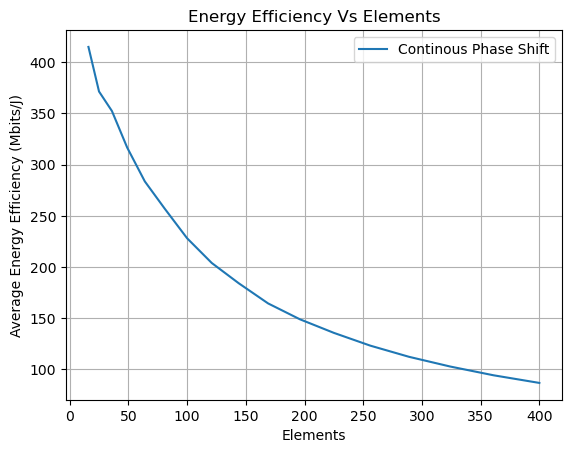

In [8]:
# Plot the graph for each value of N
plt.plot(N_values, average_energy_efficiency_Dc, label='Continous Phase Shift')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Elements')
plt.title('Energy Efficiency Vs Elements')
plt.legend()
plt.grid(True)
plt.show()



Practical Discrete Case Double IRS

In [12]:
RATE_THRESHOLD = 10
qB = np.arange(1,4,1)
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(4, Ns_max_sqrt + 1)])
# print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))
avg_EE = np.zeros((len(N_values), 1))



    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 2,3,4 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

for B in qB:
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()
        
        irs_coords_2 = generate_irs_coordinates_3D(xs_2, ys_2, zs_2, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_2 = irs_coords_2
        # print('IRS 2 elements coordinates:'"\n", loc_S_2) 
        # print()
        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        dTU, dSU_2, dTS_2 = calculate_distances_3D(loc_U, loc_T, loc_S_2)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Compute row-wise averages
        dSU_2 = np.mean(dSU_2, axis=1, keepdims=True)
        dSU_2 = dSU_2.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_2 = np.mean(dTS_2, axis=1)
        # Compute the average of row sums
        dTS_2 = np.mean(dTS_2)

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
            theta_2 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk2, g= G_2, K= K, Ns= Ns, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set )

            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)
            results_array_2 = prod_matrix(theta_2, h_rk2_h, G_2, K, Ns)
        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ALPHA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1)))  + (results_array_2[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_2**BETA1))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
            # print('For N:', Ns, 'Sum rate:', arr_sumrate_disc) 

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_22 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/1e6)
        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
        # Compute average energy efficiency for the current N
        # avg_EE[Ns,0] = compute_average_energy_efficiency(EE)   
        # Append sum-rate for this T to the list
        # sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))
    
    # Store the results in the dictionary with N as the key
    # results_dict_1[B] = sum_rates_1
    
    # Store the results in the dictionary with N as the key
    results_dict_2[B] = average_energy_efficiency_1

DoubleB3 = results_dict_2[3]

# # print(EE)
# print('done')
# print(N_values)

f:\GitHUB\Bilal_Codes\SISO_Network_Implementation_new\Functions.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  B[m] = ((1 - B_min) * ((np.sin(nearest_quantized_theta[m] - phi) + 1) / 2) ** a + B_min)


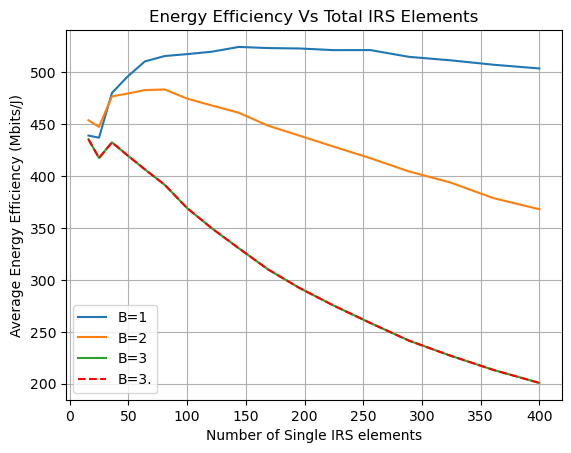

In [13]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'B={B}')

plt.plot(N_values, DoubleB3,'--r' ,label='B=3.')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Number of Single IRS elements')
plt.title('Energy Efficiency Vs Total IRS Elements')
plt.legend()
plt.grid(True)
plt.show()


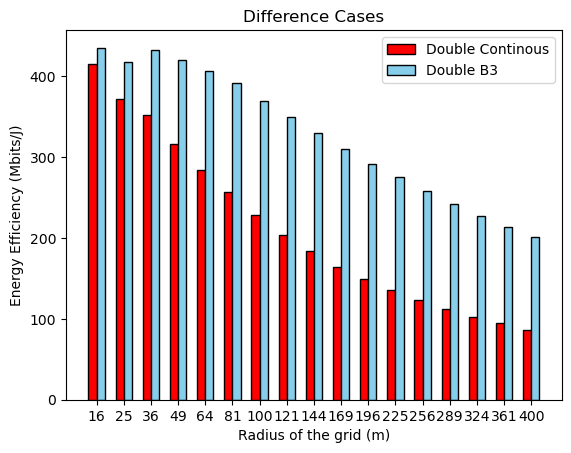

In [14]:
# Set width of bar
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(average_energy_efficiency_Dc))
r2 = [x + bar_width for x in r1]

# Plotting the bar charts
plt.bar(r1, average_energy_efficiency_Dc, color='red', width=bar_width, edgecolor='black', label='Double Continous')
plt.bar(r2, DoubleB3, color='skyblue', width=bar_width, edgecolor='black', label='Double B3')

# Adding labels and ticks
plt.xlabel('Radius of the grid (m)')
plt.ylabel('Energy Efficiency (Mbits/J)')
plt.title('Difference Cases')
plt.xticks([r + bar_width / 2 for r in range(len(average_energy_efficiency_Dc))], N_values)
plt.legend()
plt.show()

# SINGLE IRS CASE

User positions:
 [[-3.60456703e+01  3.59012453e+02  0.00000000e+00]
 [ 1.96470373e+02  7.23124757e+01  0.00000000e+00]
 [-1.44694371e+02 -2.15594585e+02  0.00000000e+00]
 [-1.31946783e+02 -6.46938626e+02  0.00000000e+00]
 [ 3.06838028e+01 -2.40899242e+02  0.00000000e+00]
 [-1.93337880e+02 -2.12919299e+02  0.00000000e+00]
 [ 9.71916508e+02  2.01301653e+02  0.00000000e+00]
 [ 1.39286292e+02  4.61707247e+02  0.00000000e+00]
 [ 3.64448302e+01  3.42670522e+01  0.00000000e+00]
 [-1.10476893e+02 -9.46356954e+00  0.00000000e+00]
 [-1.06734198e+02 -2.04155147e+02  0.00000000e+00]
 [ 2.29581748e+02  7.60249320e+01  0.00000000e+00]
 [-6.79425053e-01 -2.36686026e+00  0.00000000e+00]
 [ 2.14611022e+01  2.67193808e+01  0.00000000e+00]
 [-2.02858370e+02  1.11937702e+02  0.00000000e+00]
 [-9.18548752e+01  7.04404499e+01  0.00000000e+00]]
BS position:
 (0, 0, 20)
IRS-1 position:
 (60, 80, 10)


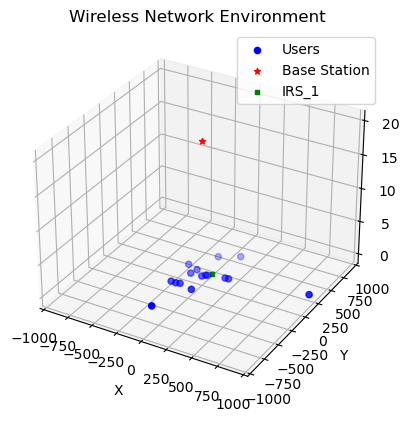

In [15]:

xt, yt, zt = BASE_STATION_POSITION
xs_1, ys_1, zs_1 = IRS_POSITION_1

fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(USER_POS[:, 0], USER_POS[:, 1], color='blue', marker='o', label='Users')
ax.scatter(xt, yt, zt, color='red', marker='*', label='Base Station')
plt.scatter(xs_1, ys_1, zs_1, color='green', marker='s', label='IRS_1')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.axis([-1000,1000,-1000,1000])
ax.set_title('Wireless Network Environment')
plt.legend()
# ax.legend()
ax.grid(True)

print('User positions:'"\n" , USER_POS)
print('BS position:'"\n" , BASE_STATION_POSITION)
print('IRS-1 position:'"\n" , IRS_POSITION_1)

loc_T = np.array([BASE_STATION_POSITION])
loc_U = USER_POS



In [16]:
h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

# BS to IRS
G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

# IRS to Users
h_rk1_ns_values = [h_rk1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)


Ideal Continuous Case Single IRS

In [17]:
RATE_THRESHOLD = 10
B = None
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(4, Ns_max_sqrt + 1)])
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))
avg_EE = np.zeros((len(N_values), 1))



    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 1,2,3 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

average_energy_efficiency_Sc = []
sum_rates_1 = []

for Ns in N_values:
    nIRSrow = int(np.sqrt(Ns))
    nIRScol = nIRSrow
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
    
    irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
    loc_S_1 = irs_coords_1
    # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
    # print()

    
    dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
    
    # Reshapiing the distance from antennas/BS to user
    dTU = dTU.reshape(Nt,K)
    # Compute row-wise averages
    dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
    dSU_1 = dSU_1.reshape(1,K)
    # Compute the sum of elements in each row
    dTS_1 = np.mean(dTS_1, axis=1)
    # Compute the average of row sums
    dTS_1 = np.mean(dTS_1)
    # Compute row-wise averages

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
    # Direct Link
    h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

    # BS to IRS
    G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

    # IRS to Users
    h_rk1_ns_values = [h_rk1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
    h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    # Initialize list to store individual outage probabilities
    energy_efficiency = []

    # Initialize sum-rates for this case
    sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
    for s in range(NUM_SIMULATIONS):
        h_dk = h_dk_3d[s] # Shape: (K, 1)
        h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
        h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
        G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

        h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
        h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
        G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
        
        theta_1 = theta_matrix_ideal(1, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, quantized_theta_set= None)
        results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

    # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
        arr_link_budget = np.zeros((K,1))
        for m in range (K):
            arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ALPHA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1))))))
            arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
            arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
            arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
            outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
        arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
        # print('For N:', Ns, 'Sum rate:', arr_sumrate_disc) 

        power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
        power_21 = compute_power_consumption_at_ris(B, Ns)
        power_22 = compute_power_consumption_at_ris(B, Ns)
        power_3 = (10**(Pu/10))/1000
        power_3 = power_3 * K
        P = power_1 + power_21 + power_3

        # Compute the energy_efficiency
        ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
        energy_efficiency.append(ee/1e6)
    average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
    average_energy_efficiency_Sc.append(average_energy_efficiencies_1)

    # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    # Compute average energy efficiency for the current N
    # avg_EE[Ns,0] = compute_average_energy_efficiency(EE)   
    # Append sum-rate for this T to the list
    # sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))

# Store the results in the dictionary with N as the key
# results_dict_1[B] = sum_rates_1

# Store the results in the dictionary with N as the key

# # print(EE)
# print('done')
# print(N_values)

print(average_energy_efficiency_Sc)

[ 16  25  36  49  64  81 100 121 144 169 196 225 256 289 324 361 400]
[424.03752824898055, 398.0051918709112, 410.61475909125664, 388.54450030792003, 362.18262765089565, 340.34237393858797, 316.58453578094856, 291.09880322824165, 271.521356915152, 249.82617476400898, 231.342022446477, 214.52211622770326, 197.91539121506446, 183.11301437842394, 170.6164142400081, 157.78261101479475, 147.1938009262993]


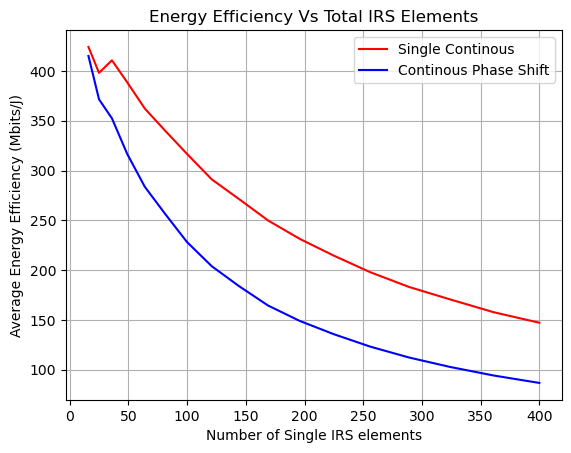

In [18]:
plt.plot(N_values, average_energy_efficiency_Sc, 'r', label='Single Continous')
plt.plot(N_values, average_energy_efficiency_Dc, 'b', label='Continous Phase Shift')


plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Number of Single IRS elements')
plt.title('Energy Efficiency Vs Total IRS Elements')
plt.legend()
plt.grid(True)
plt.show()

# # Plot the graph for each value of N
# for B, sum_rates_1 in results_dict_1.items():
#     plt.plot(N_values, sum_rates_1, label=f'B={B}')

# plt.ylabel('Sum rate')
# plt.xlabel('Number of IRS elements')
# plt.title('Sum Rates Vs IRS Elements')
# plt.legend()
# plt.grid(True)
# plt.show()

Practical Discrete Case Single IRS

In [31]:
RATE_THRESHOLD = 10
qB = np.arange(1,4,1)
Ns_max_sqrt = int(np.sqrt(Ns_max))
N_values = np.array([i**2 for i in range(4, Ns_max_sqrt + 1)])
print(N_values)


arr_sumrate_disc = np.zeros((NUM_SIMULATIONS,1))
arr_rate_disc = np.zeros((NUM_SIMULATIONS,K,1))
outage_probability_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_SNR_disc = np.zeros((NUM_SIMULATIONS,K,1))
arr_lb_disc = np.zeros((NUM_SIMULATIONS,K,1))
avg_EE = np.zeros((len(N_values), 1))



    # Create a set of quantized theta values
    # quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    # print('Quantized_theta_set: ',"\n", (quantized_theta_set))

# Initialize an empty dictionary to store the results
results_dict_1 = {}
results_dict_2 = {}
# -------------------------------------------------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- SETTING UP SIMULATION ENVIRONMENT------------------------------------------------------------------------------
# ----------------------------------for Quantization Bits = 1,2,3 and different values of IRS elements---------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------

for B in qB:
    quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)
    average_energy_efficiency_1 = []
    sum_rates_1 = []

    for Ns in N_values:
        nIRSrow = int(np.sqrt(Ns))
        nIRScol = nIRSrow
# -------------------------------------------------------------Calculating distances-----------------------------------------------------------------------------------
        
        irs_coords_1 = generate_irs_coordinates_3D(xs_1, ys_1, zs_1, nIRSrow, nIRScol, halfLambda, quarterLambda)
        loc_S_1 = irs_coords_1
        # print('IRS 1 elements coordinates:'"\n", loc_S_1) 
        # print()

        
        dTU, dSU_1, dTS_1 = calculate_distances_3D(loc_U, loc_T, loc_S_1)
        
        # Reshapiing the distance from antennas/BS to user
        dTU = dTU.reshape(Nt,K)
        # Compute row-wise averages
        dSU_1 = np.mean(dSU_1, axis=1, keepdims=True)
        dSU_1 = dSU_1.reshape(1,K)
        # Compute the sum of elements in each row
        dTS_1 = np.mean(dTS_1, axis=1)
        # Compute the average of row sums
        dTS_1 = np.mean(dTS_1)
        # Compute row-wise averages

# -------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------Extracting Channel Values for current Ns value-----------------------------------------------------------------------------------
        # Direct Link
        h_dk = [h_dk_3d[s] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, 1)

        # BS to IRS
        G1_ns_values = [G1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, 1)

        # IRS to Users
        h_rk1_ns_values = [h_rk1_3d[s][:Ns, :] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, Ns, K)
        h_rk1_h_ns_values = [h_rk1_h_3d[s][:, :Ns] for s in range(NUM_SIMULATIONS)]  # Shape: (NUM_SIMULATIONS, K, Ns)
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        # Initialize list to store individual outage probabilities
        energy_efficiency = []

        # Initialize sum-rates for this case
        sum_rate = []

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  ---------------------------------------------------------RUNNING SIMULATIONS---------------------------------------------------------------------------------------------------------------------
        for s in range(NUM_SIMULATIONS):
            h_dk = h_dk_3d[s] # Shape: (K, 1)
            h_rk1 = h_rk1_ns_values[s]  # Shape: (Ns, K)
            h_rk1_h = h_rk1_h_ns_values[s]  # Shape: (K, Ns)
            G_1 = G1_ns_values[s]  # Shape: (Ns, 1)

            h_rk2 = h_rk2_ns_values[s]  # Shape: (Ns, K)
            h_rk2_h = h_rk2_h_ns_values[s]  # Shape: (K, Ns)
            G_2 = G2_ns_values[s]  # Shape: (Ns, 1)
            
            theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G_1, K= K, Ns= Ns, B_min= B_min, phi= phi, a=a, quantized_theta_set= quantized_theta_set)
            results_array_1 = prod_matrix(theta_1, h_rk1_h, G_1, K, Ns)

        # ------------------------------------------------------------Calculating LB, Rate, SNR, EE----------------------------------------------------------------------------------------------------------------------------------------------
            arr_link_budget = np.zeros((K,1))
            for m in range (K):
                arr_link_budget[m] = np.abs((TRANSMIT_POWER_WATTS**0.5)* ((h_dk[m]/np.sqrt(dTU[:,m]**ALPHA)) + ((results_array_1[m]/np.sqrt((dSU_1[:,m]**BETA2)*(dTS_1**BETA1))))))
                arr_link_budget[m] = pow2dBm(np.abs(arr_link_budget[m])**2)
                arr_SNR_disc[s,m,:] = compute_SNR(arr_link_budget[m],noise)
                arr_rate_disc[s,m,:] = compute_rate(arr_SNR_disc[s,m,:]) * BW
                outage_probability_disc[s,m,:] = compute_outage_probability(K, arr_rate_disc[s,m,:], RATE_THRESHOLD)
            arr_sumrate_disc[s] = (np.sum(arr_rate_disc[s,:,:]))
            # print('For N:', Ns, 'Sum rate:', arr_sumrate_disc) 

            power_1 = compute_power_at_base_station(wn, TRANSMIT_POWER_WATTS, Pb)
            power_21 = compute_power_consumption_at_ris(B, Ns)
            power_22 = compute_power_consumption_at_ris(B, Ns)
            power_3 = (10**(Pu/10))/1000
            power_3 = power_3 * K
            P = power_1 + power_21 + power_3

            # Compute the energy_efficiency
            ee = compute_energy_efficiency(arr_sumrate_disc[s], P)
            energy_efficiency.append(ee/1e6)

        average_energy_efficiencies_1 = compute_average_energy_efficiency(energy_efficiency)
        average_energy_efficiency_1.append(average_energy_efficiencies_1)

        # ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
        # Compute average energy efficiency for the current N
        # avg_EE[Ns,0] = compute_average_energy_efficiency(EE)   
        # Append sum-rate for this T to the list
        # sum_rates_1.append((np.sum(sum_rate)/NUM_SIMULATIONS))
    
    # Store the results in the dictionary with N as the key
    # results_dict_1[B] = sum_rates_1
    
    # Store the results in the dictionary with N as the key
    results_dict_2[B] = average_energy_efficiency_1



SingleB3 = results_dict_2[3]

# # print(EE)
# print('done')
# print(N_values)

[ 16  25  36  49  64  81 100 121 144 169 196 225 256 289 324 361 400]


f:\GitHUB\Bilal_Codes\SISO_Network_Implementation_new\Functions.py:621: ComplexWarning: Casting complex values to real discards the imaginary part
  B[m] = ((1 - B_min) * ((np.sin(nearest_quantized_theta[m] - phi) + 1) / 2) ** a + B_min)


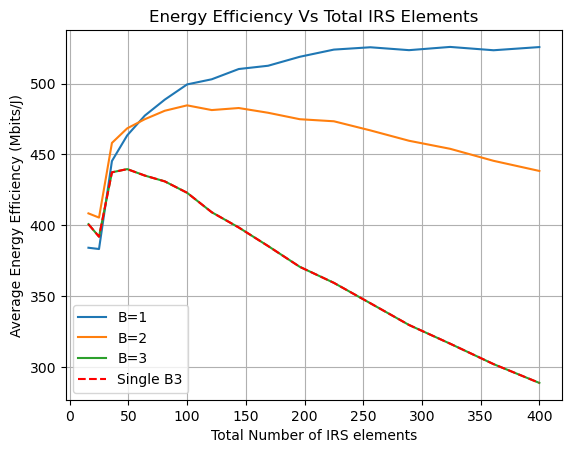

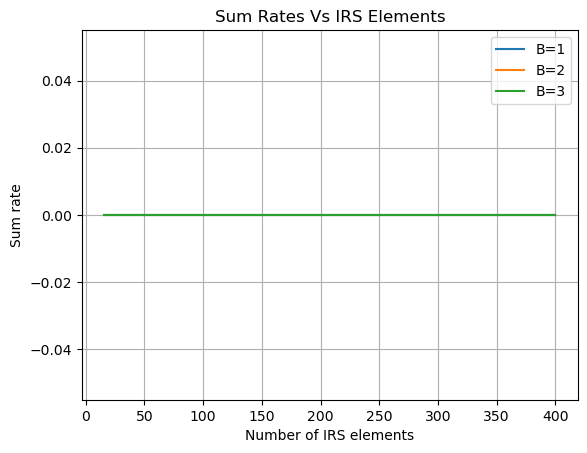

In [32]:
# Plot the graph for each value of N
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'B={B}')

plt.plot(N_values, SingleB3, '--r', label='Single B3')

plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Total Number of IRS elements')
plt.title('Energy Efficiency Vs Total IRS Elements')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
# Plot the graph for each value of N
for B, sum_rates_1 in results_dict_1.items():
    plt.plot(N_values, sum_rates_1, label=f'B={B}')

plt.ylabel('Sum rate')
plt.xlabel('Number of IRS elements')
plt.title('Sum Rates Vs IRS Elements')
plt.legend()
plt.grid(True)
plt.show()

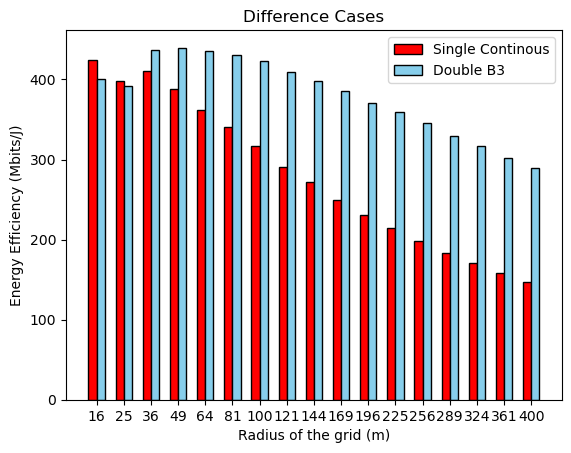

In [21]:
# Set width of bar
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(average_energy_efficiency_Dc))
r2 = [x + bar_width for x in r1]

# Plotting the bar charts
plt.bar(r1, average_energy_efficiency_Sc, color='red', width=bar_width, edgecolor='black', label='Single Continous')
plt.bar(r2, SingleB3, color='skyblue', width=bar_width, edgecolor='black', label='Double B3')

# Adding labels and ticks
plt.xlabel('Radius of the grid (m)')
plt.ylabel('Energy Efficiency (Mbits/J)')
plt.title('Difference Cases')
plt.xticks([r + bar_width / 2 for r in range(len(average_energy_efficiency_Dc))], N_values)
plt.legend()
plt.show()

In [ ]:
for B, average_energy_efficiency_1 in results_dict_2.items():
    plt.plot(N_values, average_energy_efficiency_1, label=f'B={B}')

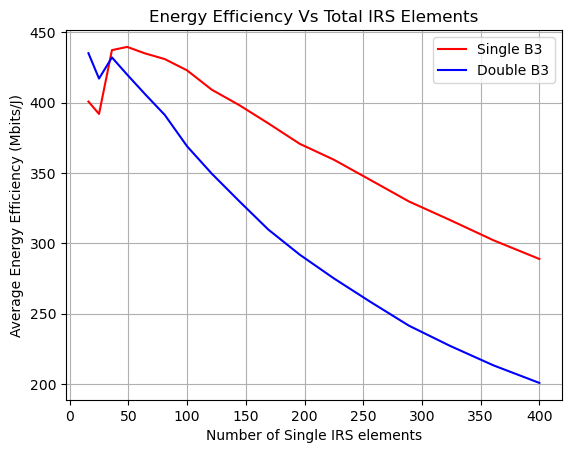

In [22]:
plt.plot(N_values, SingleB3, 'r', label='Single B3')
plt.plot(N_values, DoubleB3, 'b', label='Double B3')


plt.ylabel('Average Energy Efficiency (Mbits/J)')
plt.xlabel('Number of Single IRS elements')
plt.title('Energy Efficiency Vs Total IRS Elements')
plt.legend()
plt.grid(True)
plt.show()

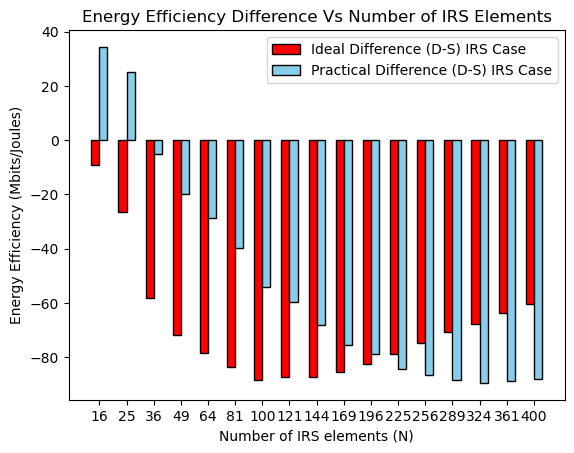

In [29]:
# Set width of bar
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(average_energy_efficiency_Dc))
r2 = [x + bar_width for x in r1]

continousdiff = np.array(average_energy_efficiency_Dc) - np.array(average_energy_efficiency_Sc)
practicalB3diff = np.array(DoubleB3) - np.array(SingleB3)  


# Plotting the bar charts
plt.bar(r1, continousdiff, color='red', width=bar_width, edgecolor='black', label='Ideal Difference (D-S) IRS Case')
plt.bar(r2, practicalB3diff, color='skyblue', width=bar_width, edgecolor='black', label='Practical Difference (D-S) IRS Case')

# Adding labels and ticks
plt.xlabel('Number of IRS elements (N)')
plt.ylabel('Energy Efficiency (Mbits/Joules)')
plt.title('Energy Efficiency Difference Vs Number of IRS Elements')
plt.xticks([r + bar_width / 2 for r in range(len(average_energy_efficiency_Dc))], N_values)
plt.legend()
plt.show()

In [37]:
N_values_T = np.transpose(np.reshape((N_values), (1,len(N_values))))
r1_T = np.transpose(np.reshape((r1), (1,len(r1))))
r2_T = np.transpose(np.reshape((r2), (1,len(r2))))
continousdiff_T = np.transpose(np.reshape((continousdiff), (1,len(continousdiff))))
practicalB3diff_T = np.transpose(np.reshape((practicalB3diff), (1,len(practicalB3diff))))

stacked_array = np.hstack((N_values_T, r1_T, r2_T, continousdiff_T, practicalB3diff_T))
stacked_array = np.array(stacked_array)

header = ['NValues','r1', 'r2', 'continousdiff', 'practicalB3diff']
file_path = './CSVDataFiles/BarDiffernce2.csv'

np.savetxt(file_path, stacked_array, delimiter=',', header=','.join(header), comments='')

TEST

In [26]:
An = [1,2,3,4,5,6,7,8,9,10]
An = np.array(An)
Bn = [1,2,3,4,5,3,2,1,4,5]
Bn = np.array(Bn)

print(An-Bn)

[0 0 0 0 0 3 5 7 5 5]


In [22]:
# h_dk = np.zeros((K,1))
# h_dk = np.array(generate_rayleigh_fading_channel(K,FADING_STD_MEAN,FADING_STD_DEV))
# h_dk = np.reshape(h_dk ,(K,1))


# # Generate the Nakagami Channel from each user to the IRS-1 (h_rk1)
# fading = []
# for user in range(K):
#     fading.append(generate_nakagami_samples(m,omega,Ns_max)) 
# h_rk1 = fading
# h_rk1 = np.reshape(h_rk1,(Ns_max,K))
# h_rk1_transpose = np.transpose(h_rk1)
# h_rk1_h = np.conj(h_rk1_transpose)


# # Generate the Nakagami Channel from base_station to the IRS-1 (G1)
# G1 = generate_nakagami_samples(m,omega,Ns_max) 
# G1 = np.reshape(G1,(Ns_max,1))

In [23]:
# def theta_matrix_practical(continuous, h_dk, h_rk, g, K, Ns, B_min, phi, a, quantized_theta_set):
#     '''
#         Computes the phase shifts performed by each IRS element.
#         Inputs:
#             continuous = True if phase shifts are modelled as continuous (-pi to pi)
#             h_dk = Direct link from BS to user, if input as None, not considered.
#             h_rk = Indirect link from IRS to User of shape (Ns,K)
#             g = Fading channel from BS to IRS of shape (Ns, 1)
#             K = Num of Users
#             Ns = Num of IRS elements 
#             B_min = Mininum value of B for quantization
#             phi, a = Parameter for practical phase shifts
#             quantized_theta_set = Quantization according to quantization bit
#         Return:
#             Returns theta diagnol matrix, containing practical phase shifts wrt each IRS element. Shape (K,Ns,Ns)
#     '''
#     inc = int(Ns / K)
#     B = np.zeros((K,inc))
#     v = np.zeros((K,inc),dtype=np.complex128)
#     theta_n = np.zeros((K, inc), dtype=complex)
#     nearest_quantized_theta = np.zeros((K, inc), dtype=complex)

#     if(continuous == True and quantized_theta_set == None):
#             for m in range(K):
#                 for n in range(inc):
#                     theta_n[m] = wrapToPi((np.angle(h_dk[m])) - (np.angle(h_rk[m*inc:(m+1)*inc, m]) + np.angle(g[m*inc:(m+1)*inc, 0])))
#                     B[m] = (1 - B_min) * ((np.sin(theta_n[m] - phi) + 1)/2)**a + B_min
#                     v[m] = B[m] * np.exp(1j*theta_n[m])

#     else:
#             for m in range(K):
#                 for n in range(inc):
#                     theta_n[m] = wrapToPi((np.angle(h_dk[m])) - (np.angle(h_rk[m*inc:(m+1)*inc, m]) + np.angle(g[m*inc:(m+1)*inc, 0])))
#                     nearest_quantized_theta[m][n] = quantized_theta_set[np.argmin(np.abs(theta_n[m][n] - quantized_theta_set))]
#                     B[m] = ((1 - B_min) * ((np.sin(nearest_quantized_theta[m] - phi) + 1) / 2) ** a + B_min)
#                     v[m] = B[m] * np.exp(1j*nearest_quantized_theta[m])

#     theta = np.zeros((K,inc,inc), dtype= np.complex128)
#     row_val = []
#     for m in range(K):
#         row_val = v[m,:]
#         for n in range(inc):
#             theta[m,n,n] = row_val[n]
#     return theta

In [24]:
# B = 2
# quantized_theta_set = ((2 * np.pi * np.arange(0, 2**B, 1) / (2**B)) - np.pi)

# inc = int (Ns/K)
# theta_1 = np.zeros((K, inc), dtype=complex)
# theta_2 = np.zeros((K, inc), dtype=complex)
# print(dTU)
# theta_1 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G1, K= K, Ns= Ns_max, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)
# print(h_dk)
# print('buh')
# dThreshold = 100

# for m in range(K):
#     if(dTU[:,m] < dThreshold):
#           h_dk[m] = 0
#     else:
#           h_dk[m] = h_dk[m]
# print(h_dk)

# theta_2 = theta_matrix_practical(0, h_dk= h_dk , h_rk= h_rk1, g= G1, K= K, Ns= Ns_max, B_min= B_min, phi= phi, a= a, quantized_theta_set= quantized_theta_set)

# if(theta_1 == theta_2).all():
#      print('wuhu')
# # print(phi_complex2)


[[206.56552916 160.78887452]]
[[0.+0.j]
 [0.+0.j]]
buh
[[0.+0.j]
 [0.+0.j]]
wuhu


C:\Users\TQUma\AppData\Local\Temp\ipykernel_3380\1950152869.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  B[m] = ((1 - B_min) * ((np.sin(nearest_quantized_theta[m] - phi) + 1) / 2) ** a + B_min)


In [25]:
dTU = np.zeros((1,K))
for m in range(K):
    dTU[:,m] = calc_distance_3D(USER_POS[m],BASE_STATION_POSITION)
print(dTU)

[[206.56552916 160.78887452]]
